In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## define bucket in which you are trying to reach
s3 = boto3.resource('s3')
bucket_name = 'daltondencklau-data445-bucket'
bucket = s3.Bucket(bucket_name)

## define csv file to read in the bucket
file_key= 'weather.csv'

## syntax to allow us to read the file
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## reading the data file
weather = pd.read_csv(file_content_stream)
weather.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


In [2]:
## retrieving the start date to be able to create a range of dates to use
weather['hpwren_timestamp'].min()

'2011-09-10 00:00:49'

In [3]:
## selecting dates up to 10-31-11 (start date = 2011-09-10; end date = 2011-09-31)
weather['hpwren_timestamp'] = weather['hpwren_timestamp'].loc[(weather['hpwren_timestamp'] >= '2011-09-010') 
                                          & (weather['hpwren_timestamp'] < '2011-09-31')]

In [4]:
## removing NaNs
weather = weather.dropna()

In [5]:
## defining the input and target variables
X = weather[['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 
             'max_wind_direction', 'max_wind_speed', 'relative_humidity']]

In [6]:
## transforming input to 0-1 scale
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [10]:
## estimating the number of clusters to use for this dataset

## defining number of clusters to be considered
k_range = list(range(2,21))

## defining list to store results
silhouette_results = list()

## computing clusters
for i in k_range:
    
    print(i)
    
    ## defining KMeans Model
    cluster_md = KMeans(n_clusters = i, n_init = 20).fit(X)
    cluster_assignments = cluster_md.labels_
    
    ## extracting silhouette score
    silhouette = silhouette_score(X, cluster_assignments)
    
    ## storing the results
    silhouette_results.append(silhouette)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [12]:
## choosing the cluster with the highest silhouette score
silhouette_results

[0.2857628845806136,
 0.31565276429783107,
 0.30463153911426955,
 0.29005695268303716,
 0.28626127745894575,
 0.3019744717041403,
 0.2789766249414629,
 0.2853085834078106,
 0.28041645396367854,
 0.26285484096863027,
 0.2625266357621733,
 0.252335166347525,
 0.25031842899405626,
 0.24832395648815303,
 0.24668688289191207,
 0.25106409611735403,
 0.2429981558483221,
 0.2566957779965431,
 0.2613960216960882]

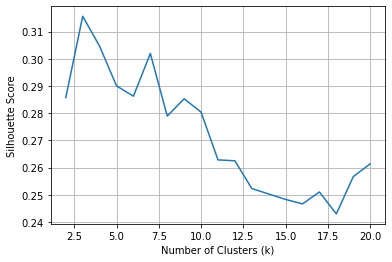

In [13]:
## visualizing results
plt.plot(range(2,21), silhouette_results)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show();

Based on the above graph and silhouette scores, I will choose the three clusters to build the following model

In [14]:
## building the KMeans model to cluster the customers
three_clusters = KMeans(n_clusters = 3, n_init = 20).fit(X)

## append the cluster label to the data
weather['clusters'] = three_clusters.labels_
weather.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity,clusters
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9,2
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0,2
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5,2
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8,2
5,5,2011-09-10 00:05:49,912.3,63.50,76.0,2.5,92.0,3.0,61.0,2.0,0.0,0.0,62.6,2


In [15]:
## describing each cluster
cluster_0 = weather[weather['clusters']== 0]
cluster_0.describe()

,rowID,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity,clusters
count,12939.000000,12939.000000,12939.000000,12939.000000,12939.000000,12939.000000,12939.000000,12939.000000,12939.000000,12939.000000,12939.000000,12939.000000,12939.0
mean,16324.394853,917.159332,74.000223,203.947137,2.210588,203.868151,2.699614,187.359533,1.701391,0.000003,0.020094,38.344030,0.0
std,8588.278712,1.308013,5.014393,51.382119,1.348469,58.828646,1.498038,53.854139,1.227544,0.000215,0.878927,13.301696,0.0
min,195.000000,911.300000,61.340000,75.000000,0.000000,0.000000,0.100000,1.000000,0.000000,0.000000,0.000000,4.900000,0.0
25%,8000.000000,916.300000,69.980000,173.000000,1.100000,182.000000,1.500000,162.000000,0.700000,0.000000,0.000000,28.200000,0.0
50%,16631.000000,917.200000,73.220000,192.000000,2.000000,201.000000,2.500000,180.000000,1.500000,0.000000,0.000000,37.800000,0.0
75%,23997.500000,917.900000,77.900000,215.000000,3.100000,224.000000,3.700000,203.000000,2.500000,0.000000,0.000000,48.500000,0.0
max,29836.000000,920.200000,91.220000,359.000000,7.700000,359.000000,8.300000,359.000000,6.900000,0.020000,60.000000,67.600000,0.0


the first cluster has an average air temperature of 74, which is much higher than the third cluster. 

In [16]:
## describing each cluster
cluster_1 = weather[weather['clusters']== 1]
cluster_1.describe()

,rowID,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity,clusters
count,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.0
mean,15744.728185,916.886998,73.590111,45.210515,1.870670,59.588242,2.239136,86.317954,1.502705,0.000001,0.001091,36.285875,1.0
std,7988.144520,1.386946,5.300919,29.381326,1.032244,32.407367,1.171992,113.109724,0.915388,0.000104,0.104439,14.451089,0.0
min,15.000000,911.300000,59.720000,0.000000,0.100000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000,4.900000,1.0
25%,8423.750000,915.800000,70.160000,22.000000,1.100000,36.000000,1.400000,21.000000,0.800000,0.000000,0.000000,25.100000,1.0
50%,15616.500000,917.100000,74.120000,42.000000,1.700000,52.000000,2.000000,42.000000,1.400000,0.000000,0.000000,30.500000,1.0
75%,24364.250000,918.000000,76.820000,63.000000,2.500000,77.000000,3.000000,78.000000,2.100000,0.000000,0.000000,48.500000,1.0
max,29844.000000,920.100000,90.320000,246.000000,5.600000,214.000000,6.600000,359.000000,5.200000,0.010000,10.000000,70.700000,1.0


In [17]:
## describing each cluster
cluster_2 = weather[weather['clusters']== 2]
cluster_2.describe()

,rowID,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity,clusters
count,7737.000000,7737.000000,7737.000000,7737.000000,7737.000000,7737.000000,7737.000000,7737.000000,7737.000000,7737.0,7737.0,7737.000000,7737.0
mean,11603.732325,915.134871,58.777169,170.833398,1.932519,182.649994,2.367739,161.162337,1.489001,0.0,0.0,76.984645,2.0
std,8500.559967,1.414250,5.077364,59.642543,1.393269,57.689054,1.570143,65.245073,1.235297,0.0,0.0,13.658511,0.0
min,1.000000,911.100000,50.900000,0.000000,0.100000,0.000000,0.100000,0.000000,0.000000,0.0,0.0,32.900000,2.0
25%,2003.000000,914.500000,53.960000,144.000000,0.800000,169.000000,1.100000,117.000000,0.500000,0.0,0.0,65.400000,2.0
50%,9719.000000,915.200000,58.280000,184.000000,1.600000,195.000000,2.000000,175.000000,1.200000,0.0,0.0,79.200000,2.0
75%,21874.000000,916.100000,63.320000,205.000000,2.700000,217.000000,3.200000,194.000000,2.200000,0.0,0.0,90.600000,2.0
max,26903.000000,918.300000,71.420000,359.000000,8.900000,358.000000,9.300000,359.000000,8.200000,0.0,0.0,91.900000,2.0


There are several features in the clusters (air_temp, avg_wind_direction, max_wind_direction, min_wind_direction, and relative_humidity) that all have distinct mean values in different clusters. It appears that the second cluster has lower averages when dealing with wind features. The rest of the features' averages are similar across all three clusters. This may pose an underfitting issue when we try and use this model on testing datasets. To combat this, I would increase the 'init' parameter, which would increase the number of iterations to run, giving us more thorough results.